In [119]:
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing 
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.pyplot import figure

In [120]:
# Read the files
npf_train = pd.read_csv("data/npf_train.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
validation = pd.read_csv("data/validation.csv")

# Define data cleaner function
def data_cleaner(df):
    data = df.copy()
    
    #remove the id, partlybad columns
    data.drop(["id","partlybad", "date"],1,inplace=True)
    
    #set new index using the date column
    #data.set_index(["date"],inplace=True)
    
    #add binary 'class2' col for event/non-event
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    
    #arrange to put class2 col at the front
    cols = ['class2'] + [col for col in data if col != 'class2']
    
    # Return cleaned and re-arranged dataframe
    return data[cols]

# Run datasets through data_cleaner
npf_train = data_cleaner(npf_train)
train = data_cleaner(train)
test = data_cleaner(test)
validation = data_cleaner(validation)

npf_train.describe()

,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,...,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,381.368963,3.259636,381.384253,3.072758,382.355206,4.195168,381.273799,2.868651,196.704452,145.639462,...,6.034562,1.645055,6.602589,1.987108,11.105194,7.854483,0.458112,0.394200,0.003137,0.000702
std,11.155961,3.023836,11.095356,2.809890,10.833336,4.284315,11.064724,2.568889,129.509968,95.584931,...,10.013342,1.005215,10.144466,1.205222,6.832233,5.151395,0.330633,0.299171,0.002211,0.000678
min,360.468984,0.164474,360.444929,0.149242,361.779070,0.152663,360.010857,0.134230,3.719434,1.997962,...,-23.768988,0.033329,-24.874583,0.031017,0.295780,0.174813,0.005346,0.003226,0.000227,0.000023
25%,373.172325,0.887424,373.254653,0.895456,374.531123,1.153497,373.310239,0.890562,74.046336,46.537218,...,-1.757175,0.791984,-1.050160,0.872620,4.898369,2.802729,0.146704,0.100064,0.001601,0.000290
50%,380.514806,2.281776,380.528337,2.187893,381.358997,2.671528,380.452108,2.073500,200.061835,154.674843,...,7.561249,1.660455,8.264583,2.006074,11.886223,8.266491,0.434569,0.373912,0.002561,0.000514
75%,388.206308,4.605244,388.209330,4.272945,388.692527,6.154840,388.163864,4.082635,313.596897,233.167716,...,14.138115,2.428618,14.621255,2.935275,17.204665,12.498510,0.723246,0.628708,0.004042,0.000871
max,421.511176,17.284759,421.057843,15.955499,422.627800,40.366704,419.924510,14.342423,425.991101,320.099476,...,24.454600,5.124718,25.215417,5.422549,22.560576,16.830501,1.242857,1.074115,0.015837,0.005078


## Correlation Matrix with Heatmap

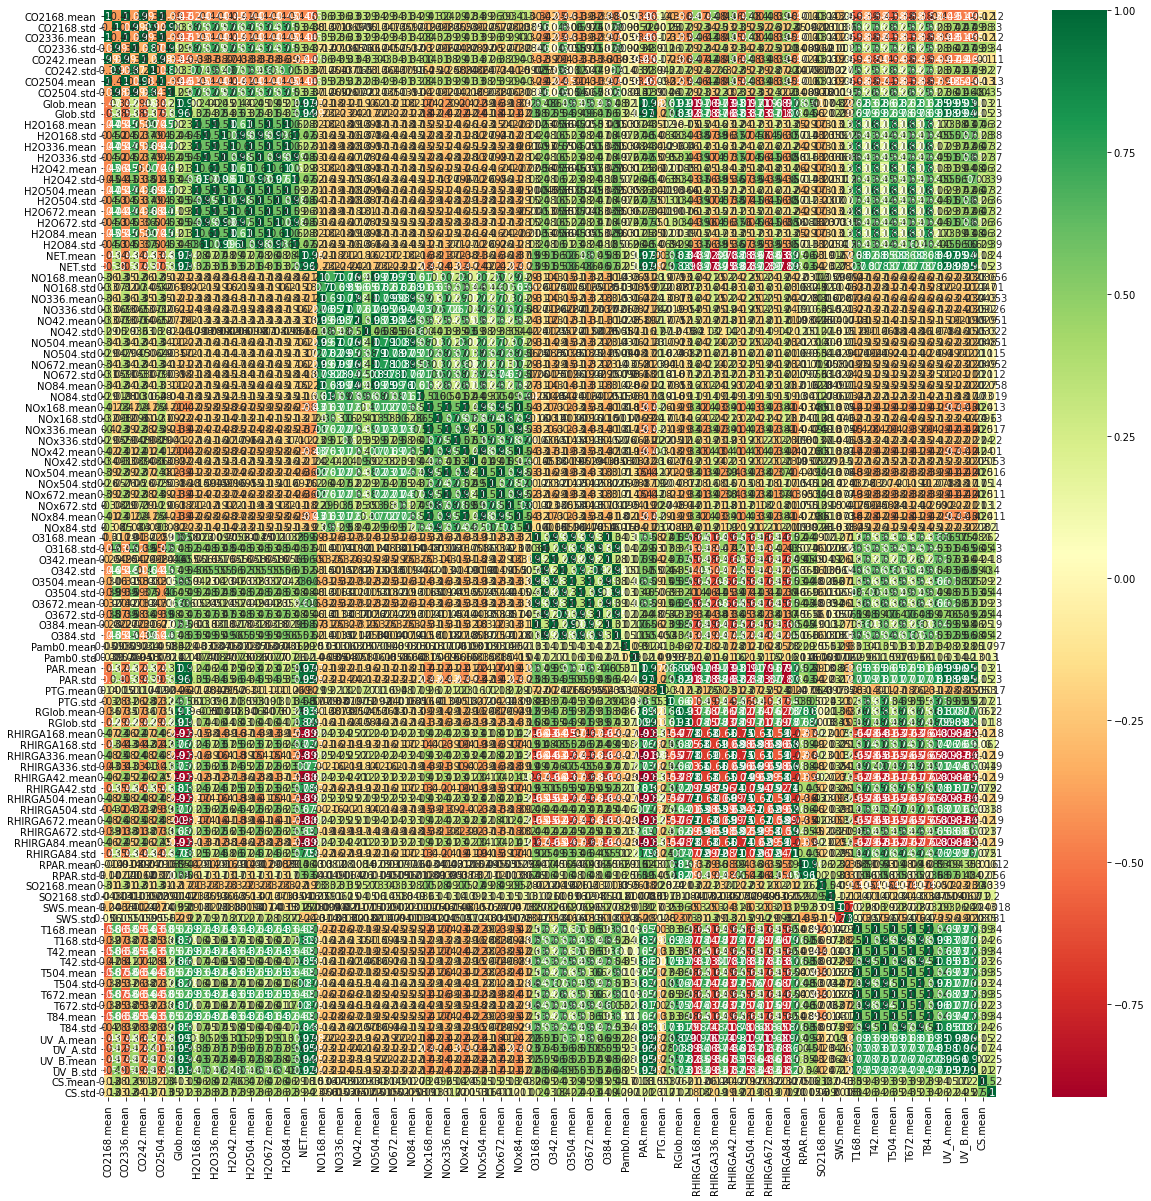

In [121]:
corrmat = npf_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(npf_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Normalize features and select n best of them

In [122]:
def normalize_0to1(X):
    # Normalize X values to be between 0 and 1
    x = X.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled)


def select_n_best_feature(X, y, n):
    # Normalize X values to be between 0 and 1
    x = X.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X = pd.DataFrame(x_scaled)

    # Use SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)

    # Concat two dataframes for better visualization and print best features
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feature_index','Score']
    #print(featureScores.nlargest(n,'Score'))

    # Filter X. Leave only top n features
    #X = bestfeatures.fit_transform(X, y)
    
    # Return X
    #return X
    return bestfeatures

## Split sets to X and y

In [123]:
X_npf_train = npf_train.iloc[:,2:]
y_npf_train = npf_train["class2"]
#X_npf_train = select_n_best_feature(X_npf_train, y_npf_train, 40)

bestFeaturesFilter = select_n_best_feature(X_npf_train, y_npf_train, 2)



y_train = train["class2"]
X_train = train.iloc[:,2:]
X_train = normalize_0to1(X_train)
X_train = bestFeaturesFilter.fit_transform(X_train, y_train)

y_val = validation["class2"]
X_val = validation.iloc[:,2:]
X_val = normalize_0to1(X_val)
X_val = bestFeaturesFilter.fit_transform(X_val, y_val)

y_test = test["class2"]
X_test = test.iloc[:,2:]
X_test = normalize_0to1(X_test)
X_test = bestFeaturesFilter.fit_transform(X_test, y_test)

## Test Gaussian Naive Bayes accurancy

In [124]:
model = GaussianNB()
model.fit(X_train, y_train)

print("Gaussian Naive Bayes binary classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Gaussian Naive Bayes binary classification
Train set accurancy: 0.76
Test set accurancy: 0.86
Validation set accurancy: 0.8


## Print graph accurancy with different number of features

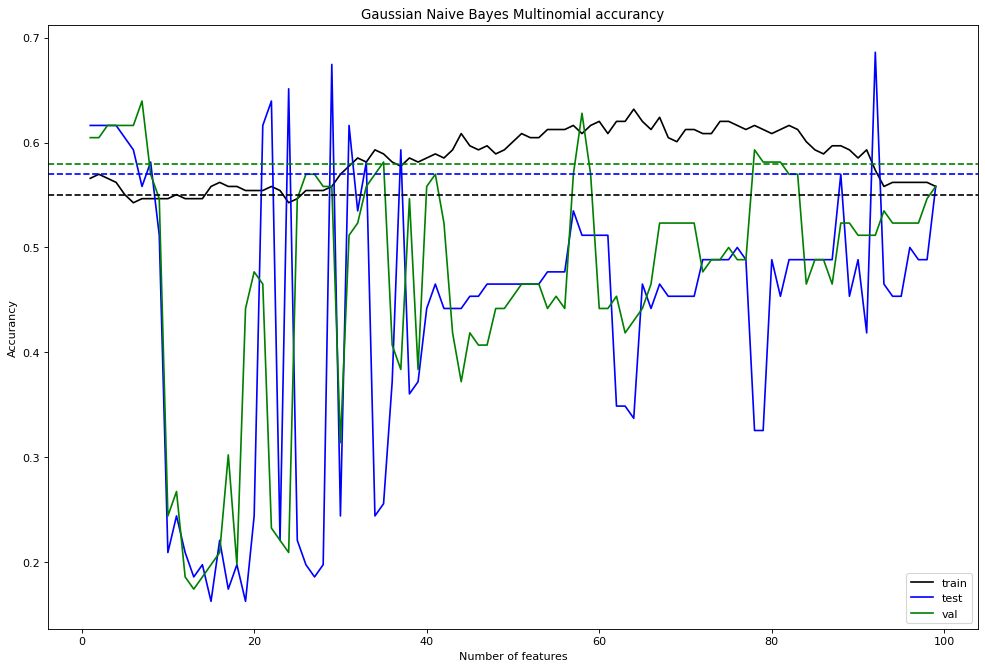

In [156]:


X_train = train.iloc[:,2:]
len_cols = len(X_train.columns)
acc_train = []
acc_test = []
acc_val = []

for i in range(1, len_cols):
    
    y_npf_train = npf_train["class4"]
    X_npf_train = npf_train.iloc[:,2:]

    y_train = train["class4"]
    X_train = train.iloc[:,2:]
    X_train = normalize_0to1(X_train)

    y_val = validation["class4"]
    X_val = validation.iloc[:,2:]
    X_val = normalize_0to1(X_val)

    y_test = test["class4"]
    X_test = test.iloc[:,2:]
    X_test = normalize_0to1(X_test)
    
    bestFeaturesFilter = 0
    bestFeaturesFilter = select_n_best_feature(X_npf_train, y_npf_train, i)
    
    X_train = bestFeaturesFilter.fit_transform(X_train, y_train)
    X_val = bestFeaturesFilter.fit_transform(X_val, y_val)
    X_test = bestFeaturesFilter.fit_transform(X_test, y_test)
    
    model = GaussianNB()
    model.fit(X_train, y_train)
    # Save accurancy to list
    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    acc_val.append(accuracy_score(y_val, model.predict(X_val)))
 
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
x = range(1, len_cols)
plt.plot(x, acc_train, color="black")
plt.plot(x, acc_test, color="blue")
plt.plot(x, acc_val, color="green")

#Train set accurancy: 0.55
plt.axhline(y=0.55, color='black', linestyle='--')
#Test set accurancy: 0.57
plt.axhline(y=0.57, color='blue', linestyle='--')
#Validation set accurancy: 0.58
plt.axhline(y=0.58, color='green', linestyle='--')

plt.title('Gaussian Naive Bayes Multinomial accurancy')
plt.xlabel('Number of features')
plt.ylabel('Accurancy')
plt.legend(["train", "test", "val"], loc ="lower right") 
plt.show()

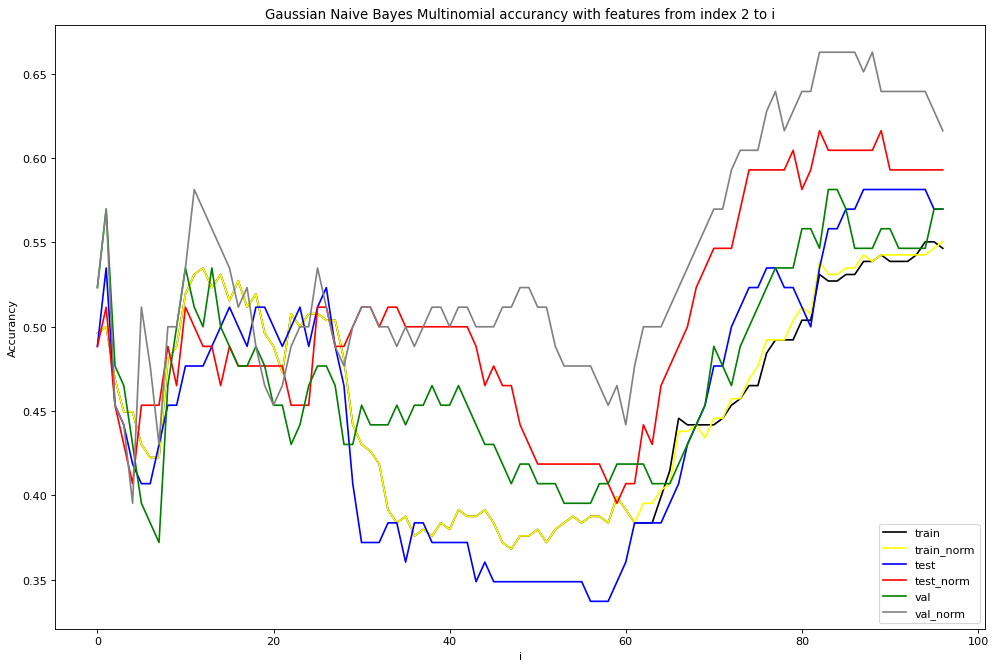

In [177]:
from matplotlib.pyplot import figure



acc_train = []
acc_test = []
acc_val = []
acc_train_norm = []
acc_test_norm = []
acc_val_norm = []

for i in range(3, len_cols):
    y_train = train["class4"]
    X_train = train.iloc[:,2:i]
    X_train_norm = normalize_0to1(X_train)
    
    y_val = validation["class4"]
    X_val = validation.iloc[:,2:i]
    X_val_norm = normalize_0to1(X_val)
    
    y_test = test["class4"]
    X_test = test.iloc[:,2:i]
    X_test_norm = normalize_0to1(X_test)
    
    # Unnormalize azzuranzy
    model = GaussianNB()
    model.fit(X_train, y_train)
    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    acc_val.append(accuracy_score(y_val, model.predict(X_val)))
    
    # Normalize azzuranzy
    model = GaussianNB()
    model.fit(X_train_norm, y_train)
    acc_train_norm.append(accuracy_score(y_train, model.predict(X_train_norm)))
    acc_test_norm.append(accuracy_score(y_test, model.predict(X_test_norm)))
    acc_val_norm.append(accuracy_score(y_val, model.predict(X_val_norm)))
 
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
x = range(0, len(acc_train))
plt.plot(x, acc_train, color="black")
plt.plot(x, acc_train_norm, color="yellow")

plt.plot(x, acc_test, color="blue")
plt.plot(x, acc_test_norm, color="red")

plt.plot(x, acc_val, color="green")
plt.plot(x, acc_val_norm, color="gray")

plt.title('Gaussian Naive Bayes Multinomial accurancy with features from index 2 to i')
plt.xlabel('i')
plt.ylabel('Accurancy')
plt.legend(["train", "train_norm", "test", "test_norm", "val", "val_norm"], loc ="lower right") 
plt.show()